In [58]:
# MONTE CARLO SIMULATION (GBM) + VaR/CVaR

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [60]:
# Import latest VOO price (closed price)
ticker = yf.Ticker("VOO")
latest = ticker.history(period="5d")
latest_close = latest['Close'].iloc[-1]

In [61]:
# Set Parameters
S0 = latest_close        # starting stock price
mu = 0.10                # expected annual return
sigma = 0.1123           # annual volatility
T = 1                    # time in years
N = 252                  # number of steps
dt = T / N               # time step size
M = 2000                # number of simulation paths
print ("S0: ", S0)

S0:  638.9400024414062


In [62]:
# Simulating GBM paths
price_paths = np.zeros((M, N+1))
price_paths[:, 0] = S0    # initialize all paths at S0

Z = np.random.normal(0, 1, size=(M, N))

for t in range(1, N+1):
    price_paths[:, t] = price_paths[:, t-1] * np.exp(
        (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    
final_prices = price_paths[:, -1]

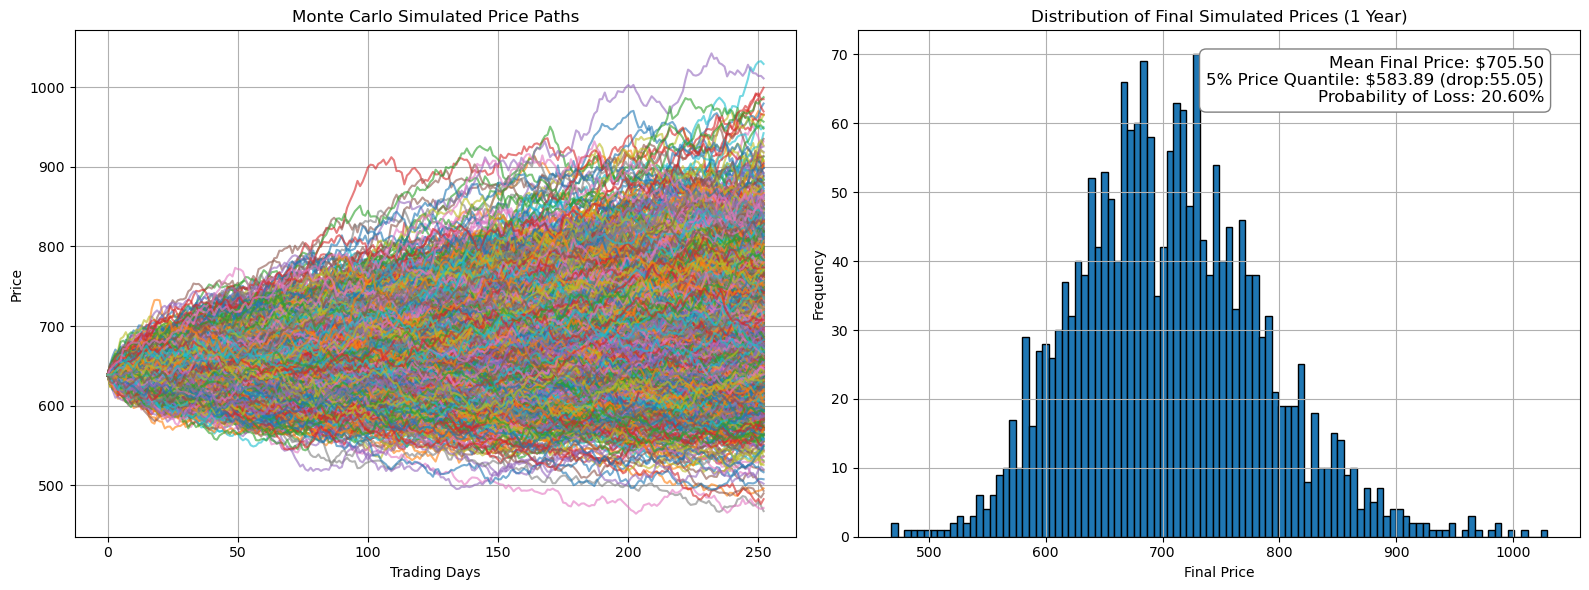

In [63]:
# PLOT
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot sample price paths 
for i in range(2000):
    axs[0].plot(price_paths[i], alpha=0.6)
axs[0].set_title("Monte Carlo Simulated Price Paths")
axs[0].set_xlabel("Trading Days")
axs[0].set_ylabel("Price")
axs[0].grid(True)

# Plot histogram of final prices 
axs[1].hist(final_prices, bins=100, edgecolor='black')
axs[1].set_title("Distribution of Final Simulated Prices (1 Year)")
axs[1].set_xlabel("Final Price")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

# price-based descrpitive metrics
mean_price = np.mean(final_prices)
price_5pct = np.percentile(final_prices, 5)
prob_loss = np.mean(final_prices < S0)

risk_text = (
    f"Mean Final Price: ${mean_price:.2f}\n"
    f"5% Price Quantile: ${price_5pct:.2f} (drop:{S0-price_5pct:.2f})\n"
    f"Probability of Loss: {prob_loss:.2%}")

plt.gca().text(
    0.95, 0.95, risk_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()

In [64]:
# Monte Carlo VaR / CVaR based on P&L

pnl = final_prices - S0    # profit and loss over horizon

alpha = 5 # 5% tail implies 95% VaR

VaR_95 = -np.percentile(pnl, alpha)
CVaR_95 = -pnl[pnl <= np.percentile(pnl, alpha)].mean()
prob_loss = np.mean (pnl<0)

print(f"VaR 95% (Loss): ${VaR_95:.2f}")
print(f"CVaR 95% (Loss): ${CVaR_95:.2f}")
print(f"Probability of Loss: ${prob_loss:.2f}")

VaR 95% (Loss): $55.05
CVaR 95% (Loss): $81.21
Probability of Loss: $0.21


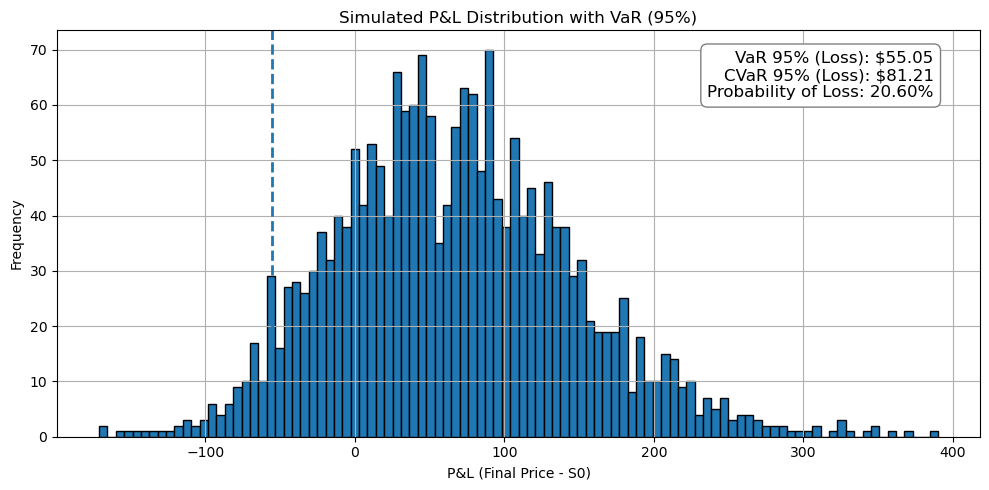

In [65]:
# 
fig, ax = plt.subplots(figsize=(10, 5))
ax.axvline(-VaR_95, linestyle='--', linewidth=2)

risk_text = (
    f"VaR 95% (Loss): ${VaR_95:.2f}\n"
    f"CVaR 95% (Loss): ${CVaR_95:.2f}\n"
    f"Probability of Loss: {prob_loss:.2%}")

plt.gca().text(
    0.95, 0.95, risk_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='gray'))

ax.hist(pnl, bins=100, edgecolor='black')
ax.set_title("Simulated P&L Distribution with VaR (95%)")
ax.set_xlabel("P&L (Final Price - S0)")
ax.set_ylabel("Frequency")
ax.grid(True)

plt.tight_layout()
plt.show()